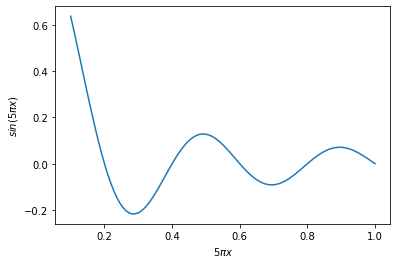

In [8]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(0.1, 1, 100)
num = np.sin(5*np.pi*X)
#den = 
y = num/(5*np.pi*X)
Y = y
plt.plot(X,Y)
plt.ylabel(r'$sin(5\pi x)$')
plt.xlabel(r'$5\pi x$')
plt.show()

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from functorch import hessian

X_t = torch.tensor(X, dtype = torch.float32)
y_t = torch.tensor(Y, dtype = torch.float32)
X_t = X_t.view(X_t.shape[0], 1)
y_t = y_t.view(y_t.shape[0], 1)

In [3]:
class func_simulator(nn.Module):
    def __init__(self):
        super(func_simulator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l2 = nn.Linear(10, 30)
        self.l3 = nn.Linear(30, 10)
        self.l4 = nn.Linear(10, 1)

    def forward(self, x):
        out = F.tanh(self.l1(x))
        out = F.tanh(self.l2(out))
        out = F.tanh(self.l3(out))
        out = F.tanh(self.l4(out))
        return out

In [4]:
learning_rate,num_epochs    = 0.1,50000
model1                      = func_simulator()
loss                        = nn.MSELoss()

In [5]:
# train on batch
def train_model(model, learning_rate, num_epochs):
    losses = []
    gradient                = torch.optim.SGD(model.parameters(),lr=learning_rate)
    for epoch in range(num_epochs):
        y_pred = model.forward(X_t)
        l = loss(y_pred,y_t)
        gradient.zero_grad() 
        #if(epoch+1)%1000==0:
#            print(f'epoch:{epoch+1},loss={l.item():.2e}')
        losses.append(l.detach().cpu.nympy())
        l.backward()
        # if epoch >= 35000:
        #     lr = 0.5*learning_rate
        gradient.step()
    return np.mean(losses)

In [9]:
from autograd_lib import autograd_lib
model = func_simulator()
autograd_lib.register(model)

In [ ]:
def calculate_grad_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.modules():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms
    return grad_mean,loss

In [ ]:
# helper function to save activations
def save_activations(layer, A, _):

    activations[layer] = A

# helper function to compute Hessian matrix
def compute_hess(layer, _, B):

    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) # do batch-wise outer product

    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA) # do batch-wise outer product, then sum over the batch

In [ ]:
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues # torch.symeig() returns eigenvalues and eigenvectors of a real symmetric matrix
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean

In [6]:
Y_bar, Ep_Loss = train_model(model1, 0.001, 100)
Loss = Ep_Loss[:,1]
print(Loss)
hessian_func = hessian(loss)
num_param = sum(p.numel() for p in model1.parameters())

[0.18249382 0.18126774 0.18004881 0.17883702 0.17763235 0.17643479
 0.17524435 0.174061   0.17288476 0.17171562 0.17055354 0.16939852
 0.16825058 0.16710968 0.16597582 0.16484898 0.16372913 0.16261633
 0.16151048 0.16041163 0.15931973 0.15823479 0.15715677 0.15608566
 0.15502146 0.15396413 0.15291367 0.15187009 0.15083332 0.14980339
 0.14878024 0.14776386 0.14675426 0.14575139 0.14475524 0.14376578
 0.14278302 0.14180689 0.14083742 0.13987455 0.1389183  0.1379686
 0.13702546 0.13608883 0.13515873 0.13423511 0.13331793 0.13240719
 0.13150285 0.13060492 0.12971334 0.12882809 0.12794916 0.12707649
 0.12621011 0.12534995 0.12449602 0.12364824 0.12280662 0.12197113
 0.12114174 0.12031842 0.11950117 0.11868992 0.11788466 0.11708537
 0.11629202 0.11550459 0.11472303 0.11394732 0.11317741 0.11241333
 0.111655   0.11090242 0.11015555 0.10941436 0.10867881 0.10794888
 0.10722455 0.1065058  0.10579256 0.10508484 0.10438257 0.10368576
 0.1029944  0.10230839 0.10162774 0.10095242 0.10028239 0.09961

/Users/mengkel/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


TypeError: forward() missing 1 required positional argument: 'target'